In [1]:


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime as datetime
import plotly.express as px

import time

# Make sure change this before import tensorflow
## Issue: https://github.com/tensorflow/tensorflow/issues/59779
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from sklearn import preprocessing
from joblib import dump, load

np.random.seed(7)



In [2]:
# Read the file
df=pd.read_csv("BTC-Hourly.csv")
print(df.dtypes)
print("\n*** DF ****")
df_copy=df.copy()
df_copy.head(3)

unix            int64
date           object
symbol         object
open          float64
high          float64
low           float64
close         float64
Volume BTC    float64
Volume USD    float64
dtype: object

*** DF ****


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
1,1646089200,2022-02-28 23:00:00,BTC/USD,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2,1646085600,2022-02-28 22:00:00,BTC/USD,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07


In [3]:
#CLEAN DATA - SPECIFICALLY CLEAN TIMESTAMP

def change_timestamp (ts):
    digit_count = len(str(ts))
    if digit_count == 12:
        return (datetime.datetime.utcfromtimestamp(ts)).strftime('%Y-%m-%d %H:%M:%S')
    else:
        return (datetime.datetime.utcfromtimestamp(ts/1000)).strftime('%Y-%m-%d %H:%M:%S')

df_copy['unix_count'] = df.unix.apply(lambda x: len(str(x)))        
df_copy['dt_correct'] = df.unix.apply(lambda x: change_timestamp(x))
df_copy['dt'] = pd.to_datetime(df_copy.dt_correct.values)
df_copy['hour'] = df_copy.dt.apply(lambda x: x.hour)
df_copy['week_day'] = df_copy.dt.apply(lambda x: x.weekday())
df_copy.sort_values(by=['unix'],ascending=[True],inplace=True)
#df_copy.drop(columns=['date','unix','symbol'],inplace=True)

print(df_copy.dtypes)
print(df_copy.unix_count.unique())
df_copy.head(5)

unix                   int64
date                  object
symbol                object
open                 float64
high                 float64
low                  float64
close                float64
Volume BTC           float64
Volume USD           float64
unix_count             int64
dt_correct            object
dt            datetime64[ns]
hour                   int64
week_day               int64
dtype: object
[10]


,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD,unix_count,dt_correct,dt,hour,week_day
33258,1526364000,2018-05-15 06:00:00,BTC/USD,8733.86,8796.68,8707.28,8740.99,4906603.14,559.93,10,1970-01-18 15:59:24,1970-01-18 15:59:24,15,6
33257,1526367600,2018-05-15 07:00:00,BTC/USD,8740.99,8766.00,8721.11,8739.00,2390398.89,273.58,10,1970-01-18 15:59:27,1970-01-18 15:59:27,15,6
33256,1526371200,2018-05-15 08:00:00,BTC/USD,8739.00,8750.27,8660.53,8728.49,7986062.84,917.79,10,1970-01-18 15:59:31,1970-01-18 15:59:31,15,6
33255,1526374800,2018-05-15 09:00:00,BTC/USD,8728.49,8754.40,8701.35,8708.32,1593991.98,182.62,10,1970-01-18 15:59:34,1970-01-18 15:59:34,15,6
33254,1526378400,2018-05-15 10:00:00,BTC/USD,8708.32,8865.00,8695.11,8795.90,11101273.74,1260.69,10,1970-01-18 15:59:38,1970-01-18 15:59:38,15,6


In [4]:
df_work = df_copy[['dt','hour','week_day','close','Volume BTC']]

#plt.figure(figsize=(15,7))
#sns.set()
#sns.lineplot(x = df_work.dt, y = 'close',data=df_work).set_title('Offline Rate')

In [5]:
#SPLIT DATA INTO TEST AND TRAIN
np.random.seed(7)

X = df_work[['hour','week_day','Volume BTC','close']]
Y = df_work[['close']]
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle = False)


#NORMALIZATION
f_transformer = preprocessing.MinMaxScaler((-1,1))
f_transformer = f_transformer.fit(X)
#X_train_trans = f_transformer.transform(X_train)
#X_test_trans = f_transformer.transform(X_test)

cnt_transformer = preprocessing.MinMaxScaler((-1,1))
cnt_transformer = cnt_transformer.fit(Y)
#y_train_trans = cnt_transformer.transform(y_train)
#y_test_trans = cnt_transformer.transform(y_test)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle = False)

X_train_trans = f_transformer.transform(X_train)
X_test_trans = f_transformer.transform(X_test)

y_train_trans = cnt_transformer.transform(y_train)
y_test_trans = cnt_transformer.transform(y_test)

#dump(f_transformer, '//Users//saad//Desktop//Bitcoin LSTM//minmax_scalar_x.bin', compress=True)
#dump(cnt_transformer, '//Users//saad//Desktop//Bitcoin LSTM//minmax_scalar_y.bin', compress=True)

print("*** SHAPES")
print("X_train: %s, %s" % (X_train.shape[0],X_train.shape[1]))
print("X_test: %s, %s" % (X_test.shape[0],X_test.shape[1]))
print("y_train: %s, %s" % (y_train.shape[0],y_train.shape[1]))
print("y_test: %s, %s" % (y_test.shape[0],y_test.shape[1]))

print("\n*** MIN MAX")

print("TRAIN COST: %d, %d" % (X_train.close.min(), X_train.close.max()))
print("TEST COST: %d, %d" % (X_test.close.min(), X_test.close.max()))
print("TRAIN VOL: %d, %d" % (X_train['Volume BTC'].min(), X_train['Volume BTC'].max()))
print("TEST VOL: %d, %d" % (X_test['Volume BTC'].min(), X_test['Volume BTC'].max()))

print("\n*** MIN MAX PARAMETER")
print(f_transformer.data_min_)
print(f_transformer.data_max_)
print(cnt_transformer.data_min_)
print(cnt_transformer.data_max_)

*** SHAPES
X_train: 26607, 4
X_test: 6652, 4
y_train: 26607, 1
y_test: 6652, 1

*** MIN MAX
TRAIN COST: 3139, 64616
TEST COST: 29189, 68627
TRAIN VOL: 0, 68570613
TEST VOL: 0, 2505

*** MIN MAX PARAMETER
[   0.      0.      0.   3139.76]
[2.30000000e+01 6.00000000e+00 6.85706132e+07 6.86270100e+04]
[3139.76]
[68627.01]


In [6]:
#CREATE LAGGING DATASET FOR TIMESERIES
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24
# reshape to [samples, time_steps, n_features]
X_train_f, y_train_f = create_dataset(X_train_trans, y_train_trans, time_steps)
X_test_f, y_test_f = create_dataset(X_test_trans, y_test_trans, time_steps)

print("*** SHAPES")
print(X_train_f.shape, y_train_f.shape)
print(X_test_f.shape, y_test_f.shape)
#print(X_train_trans.shape, y_train_trans.shape)
#print(X_test_trans.shape, y_test_trans.shape)


*** SHAPES
(26583, 24, 4) (26583, 1)
(6628, 24, 4) (6628, 1)


In [7]:
model = keras.Sequential()
model.add(keras.Input(shape=((X_train_f.shape[1], X_train_f.shape[2]))))
#model.add(layers.Bidirectional(layers.LSTM(300, activation = 'tanh', return_sequences=False)))
#model.add(layers.LSTM(300, return_sequences=False, activation = 'tanh'))
model.add(layers.LSTM(300, return_sequences=False, activation = 'tanh'))
model.add(layers.BatchNormalization())
#model.add(layers.Bidirectional(layers.LSTM(120,activation='relu', return_sequences=True)))
#model.add(keras.layers.Dropout(rate=0.2))
#model.add(layers.Flatten())
#model.add(keras.layers.Dense(units=10, activation = 'relu'))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300)               366000    
                                                                 
 batch_normalization (BatchN  (None, 300)              1200      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 367,501
Trainable params: 366,901
Non-trainable params: 600
_________________________________________________________________


In [8]:
hist = model.fit(X_train_f, y_train_f, batch_size = 200, epochs = 50, shuffle=False, validation_split=0.1)

Epoch 1/50
120/120 [==============================] - 19s 141ms/step - loss: 0.1317 - val_loss: 1.4633
Epoch 2/50
120/120 [==============================] - 18s 153ms/step - loss: 0.3132 - val_loss: 0.4716
Epoch 3/50
120/120 [==============================] - 18s 151ms/step - loss: 0.2206 - val_loss: 11.7336
Epoch 4/50
120/120 [==============================] - 20s 165ms/step - loss: 0.0855 - val_loss: 0.0403
Epoch 5/50
120/120 [==============================] - 25s 209ms/step - loss: 0.0674 - val_loss: 0.0293
Epoch 6/50
120/120 [==============================] - 25s 209ms/step - loss: 0.0491 - val_loss: 0.3034
Epoch 7/50
120/120 [==============================] - 19s 161ms/step - loss: 0.0474 - val_loss: 0.1974
Epoch 8/50
120/120 [==============================] - 19s 154ms/step - loss: 0.0474 - val_loss: 0.0866
Epoch 9/50
120/120 [==============================] - 23s 188ms/step - loss: 0.0474 - val_loss: 0.0303
Epoch 10/50
120/120 [==============================] - 22s 185ms/step - 

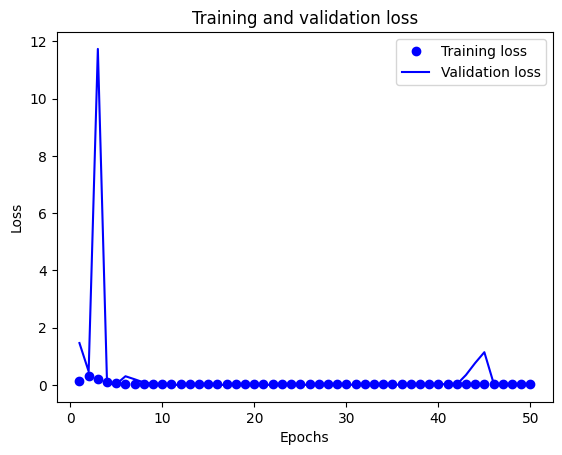

In [9]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
import math

y_pred = model.predict(X_test_f) 

y_test_inv = cnt_transformer.inverse_transform(y_test_f)
y_pred_inv = cnt_transformer.inverse_transform(y_pred)
combined_array = np.concatenate((y_test_inv,y_pred_inv),axis=1)
combined_array2 = np.concatenate((X_test.iloc[time_steps:],combined_array),axis=1)

df_final = pd.DataFrame(data = combined_array, columns=["actual", "predicted"])
print("size: %d" % (len(combined_array)))
df_final.head(4)
#testScore = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
#print('Test Score: %.2f RMSE' % (testScore))
#combined_array

208/208 [==============================] - 3s 11ms/step
size: 6628


,actual,predicted
0,35060.73,37526.410156
1,35060.14,37388.691406
2,35692.46,37387.867188
3,36244.62,37967.539062


In [11]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

results = model.evaluate(X_test_f, y_test_f)

#print("accuracy: %s" % (accuracy_score(y_test_inv, y_pred_inv)))
print("mse: %s" % (mean_squared_error(y_test_inv, y_pred_inv)))
print(results)
#print(np.sqrt(mean_squared_error(y_test_f,y_pred)))
#55,699,935.99957543

208/208 [==============================] - 2s 10ms/step - loss: 0.0025
mse: 2728397.706123684
0.002544803312048316


In [12]:
##PREPARING DATA FOR PLOTLY

a = np.repeat(1, len(y_test_inv))
b = np.repeat(2, len(y_pred_inv))

df1 = pd.DataFrame(data = np.concatenate((y_test_inv,(np.reshape(a, (-1, 1)))),axis=1), columns=["price","type"])
df2 = pd.DataFrame(data = np.concatenate((y_pred_inv,(np.reshape(b, (-1, 1)))),axis=1), columns=["price","type"])

frames = [df1, df2]
result = pd.concat(frames, ignore_index=False)

result["type"].replace({1: "actual", 2: "predict"}, inplace=True)
(result[result.type == "actual"]).head(10)

,price,type
0,35060.73,actual
1,35060.14,actual
2,35692.46,actual
3,36244.62,actual
4,36390.50,actual
5,36369.61,actual
6,36485.42,actual
7,35730.36,actual
8,36913.73,actual
9,36563.26,actual


In [13]:
#df = px.data.gapminder().query("country=='Canada'")
fig = px.line(result, x=result.index.values, y="price", color='type', title='Bitcoin Price')
fig.show()

In [14]:
# save model and architecture to single file
model.save("btc_model.h5")